In [315]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy
import copy
import os
import os.path as osp
# import pandas as pd
import glob
import imageio
import math
# from ply import *

import torch
import torch.nn.functional as F
import trimesh
# import plyfile
# import sklearn
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
import pyrender
epsilon=1e-10

import open3d as o3d; print(o3d.__version__)
def center_crop(image, h, w):
    center = image.shape
    x = center[1]/2 - w/2
    y = center[0]/2 - h/2
    crop_img = image[int(y):int(y+h), int(x):int(x+w)]
    return crop_img

def sq2ori(imsq, imori, l):
    if imori is None:
        imori = np.ones((h,w))
    img_sq = cv2.resize(imgsq,(240,240))
    img_inp = imori * 1
    img_inp[:,l:(l+240)]=img_sq
    return img_inp
root = "/Users/weifangyin/Downloads/tt/tmp"
root_result = "/home/fwei/project/NLSPN_ECCV20/experiments/221002_181731_scannettest699-3kori/test/epoch0020"
root_data = "/data/fwei/scannet/ScanNet/SensReader/python"
h,w=228,304
h0, w0 = 240,320

0.15.2


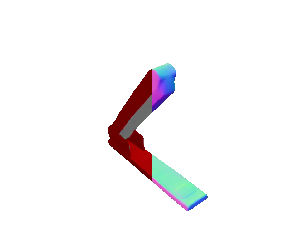

In [64]:
path = "/Users/weifangyin/research/2021facebook/cvpr2022/poster/stapler_int/n07.png"
im = imageio.imread(path)
mask = (im.sum(-1)<162)&((im.max(-1)-im.min(-1))<100)
im[mask] = 255
plt.axis('off')
plt.imshow(im[...,::-1])#,bbox_inches=0)
path = "/Users/weifangyin/research/2021facebook/cvpr2022/poster/stapler_int/07.png"
im2 = imageio.imread(path)
# mask = (im.sum(-1)<162)&((im.max(-1)-im.min(-1))<100)
im2[mask] = 255
plt.axis('off')
im3 = im * 1
im3[:,:320]=im2[:,:320]
fig=plt.imshow(im3[...,::-1])

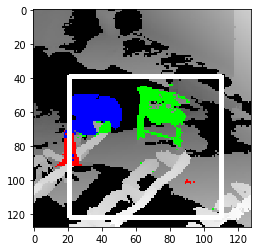

In [210]:
path = "/Users/weifangyin/Downloads/e-1/r11_dmap_pr2_nbox5_scene0657_00_vh_clean_2.png"
im = imageio.imread(path)
# imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(im[...,2], 254, 255, 0)
# thresh = (im[...,2]==255).astype(int)
thresh = ((im[...,0]==0)*(im[...,1]==255)*(im[...,2]==0)).astype(np.uint8)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = np.concatenate(contours,0)#[:,0]
bbox = np.concatenate([contours.min(0)[0],contours.max(0)[0]],0)
bbox[:2] = np.maximum(0, bbox[:2]-5)
bbox[2:] = np.minimum(128, bbox[2:]+5)
im = cv2.rectangle(im,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,255,255),2)
plt.imshow(im)

In [213]:
crop_mask = np.zeros_like(im[...,0])
crop_mask[bbox[1]:bbox[3],bbox[0]:bbox[2]] = 1
candicate_vec = (crop_mask * (thresh==0)).reshape(-1)
candidates = np.where(candicate_vec)

pick_idx = np.random.choice(candidates[0].shape[0],thresh.sum())
candidates[0][pick_idx]
pick_mask = np.zeros_like(im[...,0]).reshape(-1)
pick_mask[candidates[0][pick_idx]] = 1
pick_mask
/rgbd/users/fwei/exp/multi_clutter
#candidates[0].shape,pick_idx,,candidates[0],np.unique(candidates[0]),

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [215]:
# cv2.drawContours(im, contours, -1, (255,0,255), 1)
# bbox = np.array([128,128,0,0])

# for i in range(len(contours)):
#     xyxy = cv2.boundingRect(contours[i])
#     xyxy=np.array(xyxy)
#     bbox[:2] = np.minimum(xyxy[:2], bbox[:2])
#     bbox[2:] = np.maximum(xyxy[2:]+xyxy[:2], bbox[2:])
# bbox = cv2.boundingRect(contours)

(128, 128)

In [151]:
path = "/Users/weifangyin/Downloads/e-1/r11_dmap_pr2_nbox5_scene0657_00_vh_clean_2.png"
im = imageio.imread(path)
thresh = ((im[...,0]==0)*(im[...,1]>200)*(im[...,2]==0)).astype(np.uint8)
# imgray = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
xyxy = cv2.boundingRect(thresh*255)
bbox=xyxy

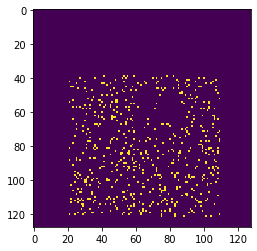

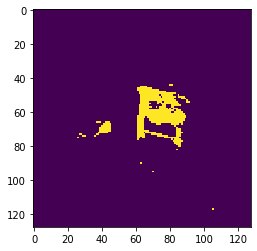

In [214]:
# img = cv2.rectangle(im,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,255,255),2)
plt.imshow(pick_mask.reshape(128,128)) #[60:62,80:82])
plt.show()
plt.imshow(thresh)
plt.show()

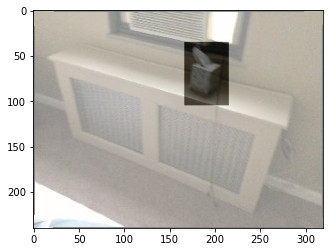

In [167]:
scene="699"
frame="1700"
fpath=f"{root_data}/scannetv2_images/scene0{scene}_00/color/{frame}.jpg"
img = imageio.imread(fpath)
l,r,u,d=167,216,35,105 #1700 26,115
# l,r,u,d=78,160,105,174 #2020  75,160,107,174
# l,r,u,d=177,208,82,118  #140
mask = np.ones_like(img)*255
mask[u:d,l:r]=0
# img[u:d,l:r] = 255
plt.imshow(((img*0.5+(mask)*0.5)/255))

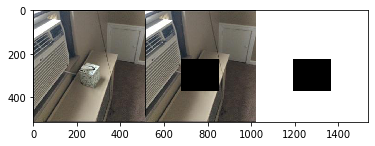

In [196]:
l=0
img_crop = img[:,l:(l+240)]
img512 = cv2.resize(img_crop, (512,512),interpolation = cv2.INTER_CUBIC)
mask_crop = mask[:,l:(l+240)]
mask512 = cv2.resize(mask_crop, (512,512),interpolation = cv2.INTER_NEAREST)
plt.imshow(np.concatenate((img512,img512*(mask512==255),mask512),1))

In [197]:
root = "/Users/weifangyin/Downloads/tt/tmp"
fsave = f"{root}/{scene}-{frame}.jpg"
imageio.imwrite(fsave, img512)
fsave = f"{root}/{scene}-{frame}-mask.jpg"
imageio.imwrite(fsave, mask512)

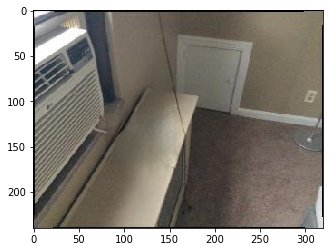

In [198]:
finpsq = f"{root}/{scene}-{frame}-inpsq.png"
img_inpsq = imageio.imread(finpsq)
img_inpsq = cv2.resize(img_inpsq,(240,240))
img_inp = img * 1
img_inp[:,l:(l+240)]=img_inpsq
plt.imshow(img_inp)
finp = f"{root}/{scene}-{frame}-inp.jpg"
imageio.imwrite(finp, img_inp)

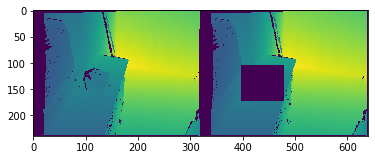

In [199]:
fdep=f"/Users/weifangyin/data/scannet/data/scannetv2_images/scene0{scene}_00/depth/{frame}.png"
dep = imageio.imread(fdep)
dep_hole = dep * (mask[...,0]==255)
plt.imshow(np.concatenate((dep,dep_hole),1)/1000)
fdep_hole = f"{root}/{scene}-{frame}-depth.png"
imageio.imwrite(fdep_hole, dep_hole)

In [293]:
from scipy.interpolate import NearestNDInterpolator
import scipy.ndimage as ndi
data = dep_hole * 1
mask = np.where(data>0)
interp = NearestNDInterpolator(np.transpose(mask), data[mask])
filled_data = interp(*np.indices(data.shape))
mean_kernel = np.full((7, 7), 1/49)
mean_data = ndi.correlate(filled_data[:228,:304], mean_kernel)

In [170]:
# "/Users/weifangyin/data/scannet/data"
path=f"{root_result}/00000001/05_pred_final_gray.png"
dep_pre = imageio.imread(path) # / 255 * 10 * 1000
scene="699"
frame="1700"
fdep=f"{root_data}/scannetv2_images/scene0{scene}_00/depth/{frame}.png"
dep = imageio.imread(fdep)
# fdep_hole = f"{root}/{scene}-{frame}-depth.png"
# dep_hole=imageio.imread(fdep_hole)
# fmask = f"{root}/{scene}-{frame}-mask.jpg"
# mask=imageio.imread(fmask)

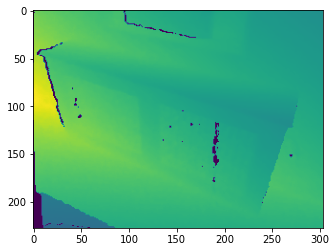

In [306]:
mask_one = mask[..., 0]//255
dep_fill = center_crop(dep * mask_one, h, w) + dep_pre * center_crop(1 - mask_one, h, w)
fdep_fill = path[:-4] + "_fillview.png"
# imageio.imwrite(fdep_fill, dep_fill.astype(np.uint16))
plt.imshow(dep_fill)

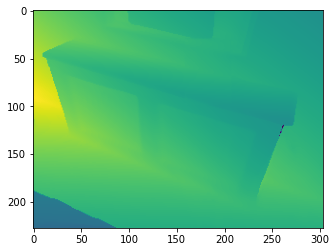

In [307]:
mask_one = mask[..., 0]//255
dep_fill = center_crop(depth * mask_one, h, w)*1000 + dep_pre * center_crop(1 - mask_one, h, w)
fdep_fill = path[:-4] + "_fillori.png"
# imageio.imwrite(fdep_fill, dep_fill.astype(np.uint16))
plt.imshow(dep_fill)

In [191]:
fname=f"{root_result}/00000001/3.obj"
mesh = trimesh.load(fname,resolver=trimesh.visual.ColorVisuals)
fname1="/Users/weifangyin/Downloads/tt/tmp/t8/00000001/1.obj"

In [192]:
# transform DepthToObj.py's output back to original coorinate system
h,w = 228,304
D = h/2/math.tan(math.pi/8)
v_cam = np.concatenate([mesh.vertices,np.ones((mesh.vertices.shape[0],1))],1)
v_cam[:,0] = v_cam[:,0] * D / 578.235840*2
v_cam[:,1] = -v_cam[:,1] * D / 575.491882*2
v_cam[:,2] = -v_cam[:,2]
v_wld = pose @ v_cam.T
mesh_wld = trimesh.Trimesh(vertices=v_wld[:3].T, faces=mesh.faces) #, vertex_colors=mesh.)
tt=mesh_wld.export(fname[:-5]+"4.ply")

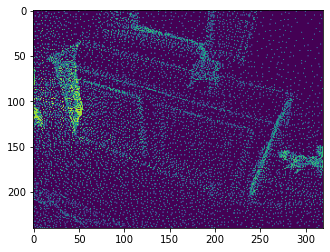

In [328]:
fcam = f"{root_data}/scannetv2_images/scene0699_00/pose/1700.txt"
with open(fcam, 'r') as f:
    lines = f.readlines()
    lines = [list(map(float, line.split())) for line in lines] 
    pose = np.array(lines)
pose_inv = np.linalg.inv(pose)
fnameori = "/data/fwei/scannet/ScanNet/SensReader/python/manual_v3/rgb_ply/scene0699_00_vh_clean_2.ply"
meshori = trimesh.load(fnameori)
# fnameori =f"{root_result}/00000001/6.obj"
# meshori = trimesh.load(fnameori)
# meshori=meshori.subdivide_to_size(0.01)
def trans_verts(meshori):
    v_camori = np.concatenate([meshori.vertices,np.ones((meshori.vertices.shape[0],1))],1)
    v_camori = pose_inv @ v_camori.T
    mesh = trimesh.Trimesh(vertices=v_camori[:3].T, faces=meshori.faces)
    return mesh#, v_camori
v_camori = trans_verts(meshori).vertices.T
K = [575.491882,578.235840,321.158966,242.023804]
K_ = [K[0]/K[2]*w0/2, K[1]/K[3]*h0/2, w0/2, h0/2]
def get_inside_mask(v_ori):
    v = v_ori * 1.0
    v[0] = v[0] * K_[0] / v[2] + K_[2]
    v[1] = v[1] * K_[1] / v[2] + K_[3]
    vr = np.round(v-0.5).astype(int) 
    inside_mask = (vr[0]>=0)*(vr[1]>=0)*(vr[0]<w0)*(vr[1]<h0)
    return inside_mask,vr
inside_mask,vr = get_inside_mask(v_camori)
imv = np.zeros((h0, w0))
imv[vr[1][inside_mask],vr[0][inside_mask]] = v_camori[2][inside_mask]
plt.imshow(imv)#np.maximum(np.maximum(imv[::2,::2],imv[1::2,1::2]),np.maximum(imv[1::2,::2],imv[::2,1::2])))

In [335]:
meshori2.visual.vertex_colors
mesh_partial_fill.visual.vertex_colors.mean(0),mesh_partial_fill.visual.vertex_colors.min(0),mesh_partial_fill.visual.vertex_colors.max(0)

AttributeError: 'TextureVisuals' object has no attribute 'vertex_colors'

In [325]:
meshori2=meshori.copy()
meshori2.update_faces(face_validmask)
meshori2.remove_unreferenced_vertices()


(<trimesh.Trimesh(vertices.shape=(152337, 3), faces.shape=(289682, 3))>,
 <trimesh.Trimesh(vertices.shape=(153041, 3), faces.shape=(291178, 3))>)

In [333]:
vertex_validmask=np.ones(meshori.vertices.shape[0])
vertex_validmask[inside_mask]=mask_one[vr[1][inside_mask],vr[0][inside_mask]]
face_validmask = vertex_validmask[meshori.faces].sum(1)==3
face_valid = meshori.faces[face_validmask]
mesh_valid = trimesh.Trimesh(vertices=meshori.vertices, faces=face_valid)#,process=False)
face_invalid = meshori.faces[~face_validmask]
mesh_invalid = trimesh.Trimesh(vertices=meshori.vertices, faces=face_invalid)#,process=False)
# mesh_valid = trimesh.Trimesh(vertices=meshori.vertices, faces=face_valid,process=False)
# mesh_valid.remove_unreferenced_vertices()
fvalid = f"{root_result}/00000001/valid2.obj"
tt=meshori2.export(fvalid)

In [334]:
fvalid = f"{root_result}/00000001/1_fillori.obj"
mesh_partial_fill = trimesh.load(fvalid)
mesh_fill = trimesh.util.concatenate(meshori2, mesh_partial_fill)
fmeshfill = f"{root_result}/00000001/mesh_fill2.obj"
tt=mesh_fill.export(fmeshfill)

In [302]:
depth_valid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [275]:
v_camori = np.concatenate([mesh_partial_fill.vertices,np.ones((mesh_partial_fill.vertices.shape[0],1))],1)
v_camori = pose_inv @ v_camori.T
inside_mask, vr = get_inside_mask(v_camori)
vertex_validmask=np.zeros(mesh_partial_fill.vertices.shape[0])
vertex_validmask[inside_mask]=1-mask_one[vr[1][inside_mask],vr[0][inside_mask]]
face_validmask = vertex_validmask[mesh_partial_fill.faces].sum(1)==3
face_valid = mesh_partial_fill.faces[face_validmask]
mesh_validmask = trimesh.Trimesh(vertices=mesh_partial_fill.vertices, faces=face_valid)
mesh_fill = trimesh.util.concatenate(mesh_validmask, mesh_valid)
fmeshfill = f"{root_result}/00000001/mesh_fillmask.obj"
tt=mesh_fill.export(fmeshfill)

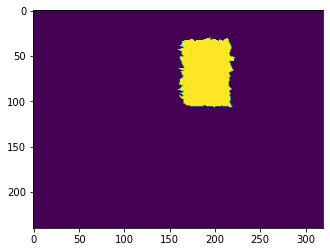

In [303]:
mask_invalid=mesh2depth(mesh_invalid)[1]>0



In [320]:
mask_dilated = scipy.ndimage.binary_dilation(mask_invalid, iterations=3)
depth_tofill = dep_fill * center_crop(mask_dilated, h, w)
fdepfillarea = f"{root_result}/00000001/depth_fillarea3.png"
imageio.imwrite(fdepfillarea,depth_tofill.astype(np.uint16))
# plt.imshow(depth_tofill)

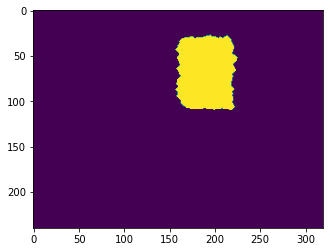

In [318]:
tt=scipy.ndimage.binary_dilation(mask_invalid, iterations=3)
plt.imshow(tt)

In [245]:
#todo
process final mesh (eg, merge close points)
output compressed ply
output colored mesh

(<trimesh.Trimesh(vertices.shape=(69301, 3), faces.shape=(137506, 3))>, 221638)

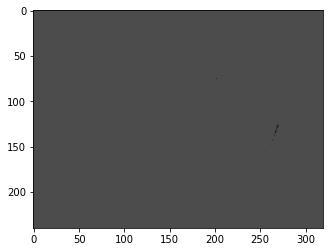

In [327]:
def mesh2depth(mesh,w0=w0,h0=h0,K=K):
    os.environ["PYOPENGL_PLATFORM"] = "egl"
    os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
    import pyrender
    r = pyrender.OffscreenRenderer(w0,h0) 
    scene = pyrender.Scene(bg_color=[0, 0, 0])
    camera = pyrender.camera.IntrinsicsCamera(K[0]/K[2]*w0/2, K[1]/K[3]*h0/2, w0/2, h0/2)
    cam_pose = np.eye(4)
    cam_pose[1, 1]=-1
    cam_pose[2, 2]=-1
    scene.add(camera, pose=cam_pose)
    #facesn = np.stack([meshori.faces[:,1],meshori.faces[:,0],meshori.faces[:,2]],-1)
    #meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=facesn) 
#     meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=meshori.faces)
    meshtrans = trans_verts(mesh)
    mesh = pyrender.Mesh.from_trimesh(meshtrans)
    scene.add(mesh)
    img, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT|pyrender.constants.RenderFlags.SKIP_CULL_FACES)
    return img, depth
img,depth=mesh2depth(meshori)
plt.imshow(depth)


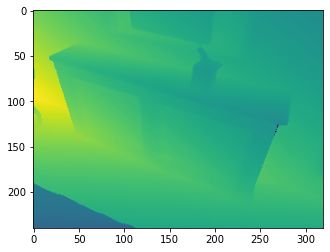

In [164]:
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
import pyrender
r = pyrender.OffscreenRenderer(w0,h0) 
scene = pyrender.Scene(bg_color=[0, 0, 0])
camera = pyrender.camera.IntrinsicsCamera(K[0]/K[2]*w0/2, K[1]/K[3]*h0/2, w0/2, h0/2)
cam_pose = np.eye(4)
cam_pose[1, 1]=-1
cam_pose[2, 2]=-1
scene.add(camera, pose=cam_pose)
#facesn = np.stack([meshori.faces[:,1],meshori.faces[:,0],meshori.faces[:,2]],-1)
#meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=facesn) 
meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=meshori.faces)
mesh = pyrender.Mesh.from_trimesh(meshtrans)
scene.add(mesh)
img, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT|pyrender.constants.RenderFlags.SKIP_CULL_FACES)
plt.imshow(depth)
fdepth = f"{root_result}/00000001/depth_ori_crop.png"
imageio.imwrite(fdepth, (depth*1000).astype(np.uint16)[8:-8,6:-6])

In [162]:
depth[0,0],depth[-1,-1],depth.shape,imv[0,0],imv[-1,-1]#,imv[1,1],imv[-2,-2]
(depth*1000).astype(np.uint16)[8:-8,6:-6].shape

(224, 308)

In [122]:
K[0]/K[2]*w0/2, K[1]/K[3]*h0/2,depth.max(),depth.shape
# np.save(f"{root_result}/00000001/depth_ori2.npy", depth)

(286.70755254580064, 286.70031481696736, 2.3603606, (240, 320))

In [65]:
mesh.primitives[0].positions #__dir__()

array([[-0.43896994,  0.32634774,  0.828     ],
       [-0.4442715 ,  0.32736623,  0.838     ],
       [-0.44904295,  0.3279278 ,  0.847     ],
       ...,
       [ 0.61778283, -0.45823458,  1.173     ],
       [ 0.6167295 , -0.4615377 ,  1.171     ],
       [ 0.61567616, -0.46482685,  1.169     ]], dtype=float32)

In [ ]:
mesh32=trimesh.Trimesh(vertices=meshori.vertices.astype(np.float32),faces=meshori.faces)
tt=mesh32.export(f"{root_result}/00000001/meshori_float32.ply")
#v_camori[:3,:3]#.dtype,depth.dtype,mesh.__dir__()

In [145]:
fdepth = f"{root_result}/00000001/depth_ori3.png"
img = o3d.io.read_image(fdepth) #np.asarray(img)
mesho3d = o3d.io.read_triangle_mesh(fnameori)

In [44]:
np.asarray(depo3d).min(),np.asarray(depo3d).max(),np.asarray(depo3d).min(),np.asarray(depo3d).max()

(1.0, 1.0, 1.0, 1.0)

In [188]:
np.asarray(depo3d).min(),np.asarray(depo3d).max()

(1.0, 1.0)

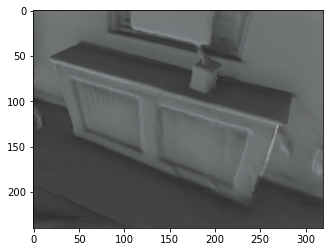

In [66]:
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
import open3d.visualization.rendering as rendering
render = rendering.OffscreenRenderer(w0,h0)

yellow = rendering.MaterialRecord()
yellow.base_color = [1.0, 0.75, 0.0, 1.0]
yellow.shader = "defaultLit"

green = rendering.MaterialRecord()
green.base_color = [0.0, 0.5, 0.0, 1.0]
green.shader = "defaultLit"

# grey = rendering.MaterialRecord()
# grey.base_color = [0.7, 0.7, 0.7, 1.0]
# grey.shader = "defaultLit"

white = rendering.MaterialRecord()
white.base_color = [1.0, 1.0, 1.0, 1.0]
white.shader = "defaultLit"

cyl = o3d.geometry.TriangleMesh.create_cylinder(.05, 3)
cyl.compute_vertex_normals()
cyl.translate([-2, 0, 1.5])
sphere = o3d.geometry.TriangleMesh.create_sphere(.2)
sphere.compute_vertex_normals()
sphere.translate([-2, 0, 3])

mesho3d = meshtrans.as_open3d
mesho3d.compute_vertex_normals()
render.scene.add_geometry("scene", mesho3d, white)
render.setup_camera(60.0, [0, 0, 0], [0, 10, 0], [0, 0, 1])
cam_int = o3d.camera.PinholeCameraIntrinsic(height=h0,width=w0,fx=K[0]/K[2]*w0/2, fy=K[1]/K[3]*h0/2, cx=w0/2, cy=h0/2)
# render.setup_camera(cam_int, cam_pose)
render.setup_camera(cam_int, np.eye(4))
render.scene.scene.set_sun_light([0.707, 0.0, -.707], [1.0, 1.0, 1.0],
                                 75000)
render.scene.scene.enable_sun_light(True)
# render.scene.show_axes(True)

img2 = render.render_to_image()
plt.imshow(img2)


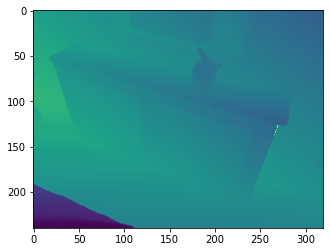

In [94]:
# depo3d = render.render_to_depth_image()
plt.imshow(np.asarray(depo3d)*depth.max())

In [68]:
np.asarray(depo3d).min(),np.asarray(depo3d).max()

(0.8754112, 1.0)

In [71]:
np.asarray(depo3d)[0,0],np.asarray(depo3d)[1,1]

(0.9458495, 0.94588053)

In [89]:
pcd=o3d.geometry.PointCloud.create_from_depth_image(depo3d, cam_int, extrinsic=np.eye(4), depth_scale=1.0, depth_trunc=1000.0, stride=1, project_valid_depth_only=True)

In [92]:
depth.min(),depth.max()

(0.0, 2.3603606)

In [77]:
o3d.io.write_point_cloud("t0.ply", pcd)

True

In [90]:
np.asarray(pcd.points).min(0),np.asarray(pcd.points).max(0)

(array([-0.53441147, -0.39589052,  0.87541121]),
 array([0.51994979, 0.3865039 , 1.        ]))

In [95]:
np.asarray(depo3d)

array([[0.9458495 , 0.945752  , 0.94564295, ..., 0.91293174, 0.9128341 ,
        0.91273654],
       [0.94598347, 0.94588053, 0.9457732 , ..., 0.91306096, 0.9129634 ,
        0.9128658 ],
       [0.946113  , 0.94600874, 0.9459018 , ..., 0.91319025, 0.9130927 ,
        0.91299504],
       ...,
       [0.8779836 , 0.87786126, 0.87773895, ..., 0.93161416, 0.931614  ,
        0.9316138 ],
       [0.8774793 , 0.8773866 , 0.8773051 , ..., 0.9313985 , 0.9313979 ,
        0.93139756],
       [0.87705165, 0.8769701 , 0.87689435, ..., 0.9311831 , 0.93118256,
        0.931182  ]], dtype=float32)

In [97]:
np.asarray(depo3d)*depth.max()

array([[2.2325459, 2.2323158, 2.2320583, ..., 2.154848 , 2.1546178,
        2.1543875],
       [2.2328622, 2.232619 , 2.2323658, ..., 2.155153 , 2.1549227,
        2.1546924],
       [2.233168 , 2.2329218, 2.2326694, ..., 2.1554582, 2.155228 ,
        2.1549976],
       ...,
       [2.072358 , 2.0720692, 2.0717804, ..., 2.1989453, 2.198945 ,
        2.1989446],
       [2.0711677, 2.0709488, 2.0707564, ..., 2.1984363, 2.198435 ,
        2.198434 ],
       [2.0701582, 2.0699656, 2.0697868, ..., 2.197928 , 2.1979268,
        2.1979253]], dtype=float32)

In [99]:
depth.shape

(240, 320)

In [98]:
depth.max()

2.3603606

In [275]:
path="/Users/weifangyin/Downloads/tt/tmp/t1/00000002/01_rgb.png"
path="/Users/weifangyin/Downloads/tt/tmp/t1/00000002/05_pred_final_graymm.png"
# path="/Users/weifangyin/Downloads/tt/tmp/t2/00000002/06_gt.png"
img = imageio.imread(path)
# img=cv2.resize(img,(320*2,240*2))
pathsave=path[:-4]+"x2.png"
# imageio.imwrite(pathsave, img)